# Brick optimisation unitary multiplication phase - trivial phase check

Created 11/09/2024

Objectives:
* Repeat for non-trivial phase.

# Package imports

In [1]:
import sys
sys.path.append('../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
from functools import reduce
from operator import mul

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.Optimizers.OneSiteSolver import OneSiteSolver

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    multiply_transfer_matrices
)

from SPTOptimization.Optimizers.utils import (
    one_site_optimization_sweep_right
)

In [6]:
import re

# Load data

In [7]:
DATA_DIR = r"../data/transverse_cluster_200_site_dmrg"

In [8]:
f_name = DATA_DIR + r"/1_10.h5"

In [9]:
f_name

'../data/transverse_cluster_200_site_dmrg/1_10.h5'

In [10]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitons

Will need to update these based off previous work...

In [11]:
MAX_VIRTUAL_BOND_DIM = 8
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [13]:
npc_I = to_npc_array(np_I)
npc_X = to_npc_array(np_X)
npc_Y = to_npc_array(np_Y)
npc_Z = to_npc_array(np_Z)

In [14]:
symmetry_actions = [
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [15]:
cases = [
    SymmetryActionWithBoundaryUnitaries(test_psi, a*50)
    for a in symmetry_actions
]

In [16]:
for c in cases:
    c.compute_svd_symmetry_action()

In [17]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [18]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

## Functions

### Leg and label functions

In [19]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [20]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [21]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [22]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [23]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [24]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [25]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [26]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

### Other

In [27]:
def contract_virtual_legs(tl, tr):
    return npc.tensordot(tl, tr, ['vR', 'vL'])

In [28]:
def combine_tensors(tensors):
    out = reduce(contract_virtual_legs, tensors)

    leg_labels = [
        extract_single_physical_leg_label_from_tensor(t)
        for t in tensors
    ]

    out = out.combine_legs(leg_labels)

    return out

In [29]:
def combine_b_tensors(b_tensors):
    renamed_tensors = [
        b.replace_label('p', f'p{i}')
        for i, b in enumerate(b_tensors)
    ]

    return combine_tensors(renamed_tensors)

In [30]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [31]:
def svd_reduce_split_tensor(t, max_inner_dim=MAX_VIRTUAL_BOND_DIM,
                           normalise=True, svd_cutoff=SVD_CUTOFF):
    U, S, VH = npc.svd(
        t,
        compute_uv=True,
        inner_labels=['vR', 'vL'],
        cutoff=svd_cutoff
    )

    # Truncate tensors:
    U = U[:, :max_inner_dim]
    S = S[:max_inner_dim]
    VH = VH[:max_inner_dim, :]

    if normalise:
        new_norm = np.sqrt(np.sum(S**2))
        S = S/new_norm

    """
    leg = VH.get_leg('vL')

    schmidt_values = npc.diag(S, leg, labels=['vL', 'vR'])
    """

    return U, S, VH

In [32]:
def split_combined_b(b, leftmost_schmidt_values,
                     max_virtual_bond_dim=MAX_INTERMEDIATE_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    t = b.split_legs()

    num_sites = t.ndim - 2

    if p_leg_labels is None:
        p_leg_labels = [f'p{i}' for i in range(num_sites)]

    out_bs = list()
    out_schmidt_values = list()

    current_left_schmidt_values = leftmost_schmidt_values

    for i, ll in enumerate(p_leg_labels[:-1]):
        t.iscale_axis(current_left_schmidt_values, axis='vL')

        tail_legs = p_leg_labels[(i+1):]
        
        t = t.combine_legs([['vL', ll], ['vR', *tail_legs]])

        U, S, VH = svd_reduce_split_tensor(
            t,
            max_inner_dim=max_virtual_bond_dim,
            normalise=True
        )

        bl = (
            U
            .split_legs()
            .replace_label(ll, 'p')
        )
        bl.iscale_axis(1/current_left_schmidt_values, axis='vL')
        bl.iscale_axis(S, axis='vR')
        bl.itranspose(['vL', 'p', 'vR'])
        out_bs.append(bl)

        out_schmidt_values.append(S)
        current_left_schmidt_values=S

        t = VH.split_legs()

    bl = t.replace_label(p_leg_labels[-1], 'p')
    bl.itranspose(['vL', 'p', 'vR'])
    out_bs.append(bl)

    return out_bs, out_schmidt_values

In [33]:
def split_b(b, max_virtual_bond_dim=MAX_INTERMEDIATE_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    leg_label = get_physical_leg_labels(b)[0]

    if is_single_physical_leg_label(leg_label):
        return b
    elif is_grouped_physical_leg_label(leg_label):
        return split_combined_b(b, max_virtual_bond_dim, p_leg_labels)
    else:
        raise ValueError

In [34]:
def split_combined_u(u, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
                     p_leg_labels=None):
    t = u.split_legs()
    num_sites = t.ndim //2
    
    if p_leg_labels is None:
        p_leg_labels = [f'p{i}' for i in range(num_sites)]

    p_leg_labels_hc = [l+'*' for l in p_leg_labels]
    out_ws = list()

    for i, (ll, ll_hc) in enumerate(zip(p_leg_labels[:-1], p_leg_labels_hc[:-1])):
        tail_legs = p_leg_labels[(i+1):]
        tail_legs_hc = p_leg_labels_hc[(i+1):]

        left_leg_labels = [ll, ll_hc]
        if 'vL' in t.get_leg_labels():
            left_leg_labels.append('vL')
    
        t = t.combine_legs([left_leg_labels, [*tail_legs, *tail_legs_hc]])

        U, S, VH = svd_reduce_split_tensor(
            t,
            max_inner_dim=max_virtual_bond_dim,
            normalise=False
        )

        U.iscale_axis(S, axis='vR')

        wl = U.split_legs().replace_labels([ll, ll_hc], ['p', 'p*'])
        #wl.itranspose(['p', 'p*'])
        out_ws.append(wl)

        t = VH.split_legs()

    wl = t.replace_labels(
        [p_leg_labels[-1], p_leg_labels_hc[-1]],
        ['p', 'p*']
    )
    #wl.itranspose(['p', 'p*'])
    out_ws.append(wl)

    out_ws[0] = (
        out_ws[0]
        .add_leg(left_trivial_leg_charge, 0, label='vL')
    )
    
    out_ws[-1] = (
        out_ws[-1]
        .add_leg(right_trivial_leg_charge, 0, label='vR')
    )

    return out_ws

In [35]:
def split_u(u, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM,
            p_leg_labels=None):
    leg_label = get_physical_leg_labels(u)[0]

    if is_single_physical_leg_label(leg_label):
        return [unitary_to_mpo_tensor(u),]
    elif is_grouped_physical_leg_label(leg_label):
        return split_combined_u(u, max_virtual_bond_dim, p_leg_labels)
    else:
        raise ValueError

In [36]:
def unitary_to_mpo_tensor(u):
    out = (
        u
        .add_leg(left_trivial_leg_charge, 0, label='vL')
        .add_leg(right_trivial_leg_charge, 0, label='vR')
    )

    return out

In [37]:
def multiply_individual_mpo_tensors(w1, w2):
    w1 = w1.replace_labels(['vR', 'vL'], ['vR1', 'vL1'])
    w2 = w2.replace_labels(['vR', 'vL'], ['vR2', 'vL2'])

    w = (
        npc.tensordot(w1, w2, [['p'], ['p*']])
        .combine_legs([['vR1', 'vR2'], ['vL1', 'vL2']])
        .replace_labels(['(vR1.vR2)', '(vL1.vL2)'], ['vR', 'vL'])
    )

    return w

In [38]:
def group_elements(l, group_size, offset=0):
    first, rest = l[:offset], l[offset:]

    num_rest_groups = ((len(rest)-1)//group_size) + 1

    groups = [first,] if first else list()

    for i in range(num_rest_groups):
        first_index = i*group_size
        last_index = (i+1)*group_size
        groups.append(rest[first_index:last_index])

    return groups

In [39]:
def combine_grouped_b_tensors(grouped_bs):
    out = list()

    for group in grouped_bs:
        if len(group) == 1:
            out.append(group[0])
        else:
            out.append(combine_b_tensors(group))

    return out

In [40]:
def reduce_virtual_mpo_dim(wl, wr, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    # wl = wl.replace_labels(['p', 'p*'], ['pl', 'pl*'])

    wl = wl.combine_legs(['p', 'vL', 'p*'])
    wr = wr.combine_legs(['p', 'vR', 'p*'])
    w = npc.tensordot(wl, wr, ['vR', 'vL'])

    wl, S, wr = svd_reduce_split_tensor(
        w,
        max_inner_dim=max_virtual_bond_dim
    )

    wl.iscale_axis(S, axis='vR')

    wl = wl.split_legs()
    wr = wr.split_legs()

    return wl, wr

In [41]:
def multiply_mpos(top_ws, bottom_ws, max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    ws = list()
    
    for w1, w2 in zip(top_ws, bottom_ws):
        w = multiply_individual_mpo_tensors(w1, w2)
        ws.append(w)


    for i in range(len(ws)-1):
        ws[i], ws[i+1] = reduce_virtual_mpo_dim(
            ws[i],
            ws[i+1],
            max_virtual_bond_dim=max_virtual_bond_dim
        )

    return ws

### Layer function

In [42]:
def optimise_layer(
        left_environment,
        top_b_tensors,
        left_schmidt_values,
        block_width,
        block_offset,
        expectations,
        unitaries=list(),
        bottom_b_tensors=None,
        num_iterations=1,
        max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM
    ):

    if bottom_b_tensors is None:
        bottom_b_tensors = top_b_tensors

    group = lambda x: group_elements(x, block_width, block_offset)
    top_grouped_bs = group(top_b_tensors)
    bottom_grouped_bs = group(bottom_b_tensors)
    grouped_schmidt_values = group(left_schmidt_values)

    top_combined_bs = combine_grouped_b_tensors(top_grouped_bs)
    bottom_combined_bs = combine_grouped_b_tensors(bottom_grouped_bs)

    new_unitaries = [
        get_identity_operator(t) for t in top_combined_bs
    ]

    expectations.append(list())

    for _ in range(num_iterations):
        exps, *_ = one_site_optimization_sweep_right(
            left_environment,
            top_combined_bs,
            new_unitaries,
            bottom_combined_bs
        )

        expectations[-1].append(exps)

    unitaries.append(new_unitaries)

    for i, u in enumerate(new_unitaries):
        b = top_combined_bs[i]
        ll = get_physical_leg_labels(b)[0]
        llh = conjugate_leg_label(ll)
    
        new_b = npc.tensordot(b, u, [[ll,], [llh,]])
    
        top_combined_bs[i] = new_b

    new_top_bs = list()
    new_left_schmidt_values = left_schmidt_values.copy()

    for b, s in zip (top_combined_bs, grouped_schmidt_values):
        leg_label = get_physical_leg_labels(b)[0]
        if is_single_physical_leg_label(leg_label):
            new_top_bs.append(b)
            new_left_schmidt_values.extend(s)
        elif is_grouped_physical_leg_label(leg_label):
            bs, schmidt_vals = split_combined_b(
                b,
                s[0],
                max_virtual_bond_dim
            )
            new_top_bs.extend(bs)
            new_left_schmidt_values.extend(s)

    """
    for i, b in enumerate(new_top_bs):
        top_b_tensors[i] = b
    """

    return new_top_bs, new_left_schmidt_values

In [43]:
def inner_product_b_tensors(b_tensors, b_bra_tensors=None, left_environment=None,
                            right_environment=None):
    if b_bra_tensors is None:
        b_bra_tensors = b_tensors

    b = b_tensors[0]
    b_bra = b_bra_tensors[0]

    if left_environment is None:
        t = npc.tensordot(b, b_bra.conj(), [['vL',], ['vL*',]])
    else:
        t = npc.tensordot(left_environment, b, [['vR',], ['vL',]])
        t = npc.tensordot(t, b_bra.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    for b, b_bra in zip(b_tensors[1:], b_bra_tensors[1:]):
        t = npc.tensordot(t, b, [['vR',], ['vL',]])
        t = npc.tensordot(t, b_bra.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    if right_environment is None:
        out = npc.trace(t)
    else:
        out = npc.tensordot(t, right_environment, [['vR', 'vR*'], ['vL', 'vL*']])

    return out

# Get MPO tensors for each case

In [44]:
test = cases[0]

In [45]:
test.right_symmetry_index

149

In [46]:
bs = [
    test_psi.get_B(i)
    for k, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 26))
]

In [47]:
left_schmidt_values = [
    test_psi.get_SL(i)
    for _, i in enumerate(range(test.right_symmetry_index + 1, test.right_symmetry_index + 26))
]

In [48]:
len(bs)

25

In [49]:
symmetry_actions

[[array([[1, 0],
         [0, 1]]),
  array([[0, 1],
         [1, 0]])],
 [array([[0, 1],
         [1, 0]]),
  array([[1, 0],
         [0, 1]])],
 [array([[0, 1],
         [1, 0]]),
  array([[0, 1],
         [1, 0]])]]

## IX

In [92]:
left_environment = cases[0].right_projected_symmetry_state
bottom_b_tensors = bs
top_b_tensors = [bs,]
left_schmidt_values_list = [left_schmidt_values,]
block_width = 7
expectations = list()
unitaries = []
num_iterations = 3

In [93]:
for i in range(10):
    if i%5 == 0:
        print(f"Layer: {i}")
    
    offset = (block_width//2)*i % block_width

    new_top_b_tensors, new_schmidt_values = optimise_layer(
        left_environment,
        top_b_tensors[-1],
        left_schmidt_values_list[-1],
        block_width,
        offset,
        expectations,
        unitaries,
        bottom_b_tensors,
        num_iterations
    )

    top_b_tensors.append(new_top_b_tensors)
    left_schmidt_values_list.append(new_schmidt_values)

Layer: 0
Layer: 5


In [94]:
final_expectations = list()

for l in expectations:
    final_expectations.append(l[-1][-1])

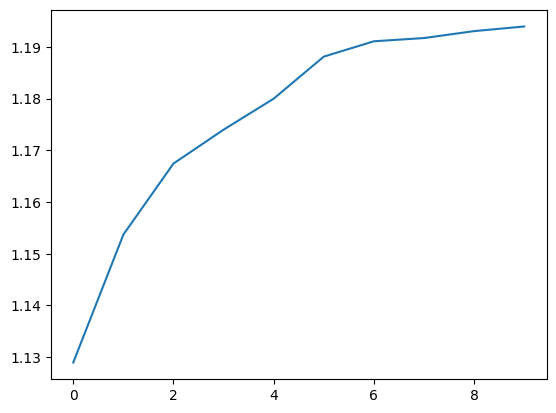

In [95]:
plt.plot(final_expectations)

In [96]:
final_expectations[-1]

1.1939683923760207

In [97]:
symmetry_action_unitaries = list()

In [98]:
ix_unitary = unitaries

In [99]:
ix_state = new_top_b_tensors

In [100]:
ix_schmidt_values = new_schmidt_values

In [101]:
symmetry_action_unitaries.append(unitaries)

## XI

In [102]:
left_environment = cases[1].right_projected_symmetry_state
bottom_b_tensors = bs
top_b_tensors = [bs,]
left_schmidt_values_list = [left_schmidt_values,]
block_width = 7
expectations = list()
unitaries = []
num_iterations = 3

In [103]:
for i in range(10):
    if i%5 == 0:
        print(f"Layer: {i}")
    
    offset = (block_width//2)*i % block_width

    new_top_b_tensors, new_schmidt_values = optimise_layer(
        left_environment,
        top_b_tensors[-1],
        left_schmidt_values_list[-1],
        block_width,
        offset,
        expectations,
        unitaries,
        bottom_b_tensors,
        num_iterations
    )

    top_b_tensors.append(new_top_b_tensors)
    left_schmidt_values_list.append(new_schmidt_values)

Layer: 0
Layer: 5


In [104]:
final_expectations = list()

for l in expectations:
    final_expectations.append(l[-1][-1])

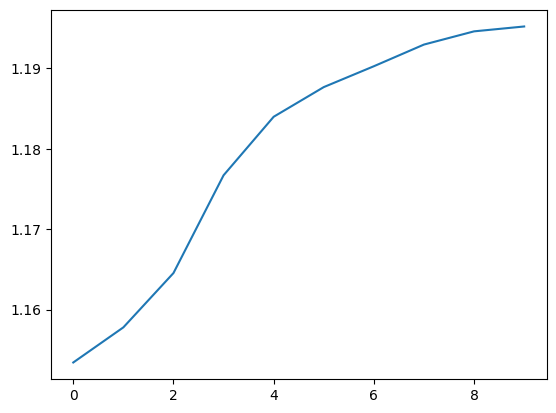

In [105]:
plt.plot(final_expectations)

In [106]:
final_expectations[-1]

1.1951930956027916

In [107]:
xi_unitary = unitaries

In [108]:
xi_state = new_top_b_tensors

In [109]:
xi_schmidt_values = new_schmidt_values

In [110]:
symmetry_action_unitaries.append(unitaries)

## XX

In [111]:
left_environment = cases[2].right_projected_symmetry_state
bottom_b_tensors = bs
top_b_tensors = [bs,]
left_schmidt_values_list = [left_schmidt_values,]
block_width = 7
expectations = list()
unitaries = []
num_iterations = 3

In [112]:
for i in range(10):
    if i%5 == 0:
        print(f"Layer: {i}")
    
    offset = (block_width//2)*i % block_width

    new_top_b_tensors, new_schmidt_values = optimise_layer(
        left_environment,
        top_b_tensors[-1],
        left_schmidt_values_list[-1],
        block_width,
        offset,
        expectations,
        unitaries,
        bottom_b_tensors,
        num_iterations
    )

    top_b_tensors.append(new_top_b_tensors)
    left_schmidt_values_list.append(new_schmidt_values)

Layer: 0
Layer: 5


In [113]:
final_expectations = list()

for l in expectations:
    final_expectations.append(l[-1][-1])

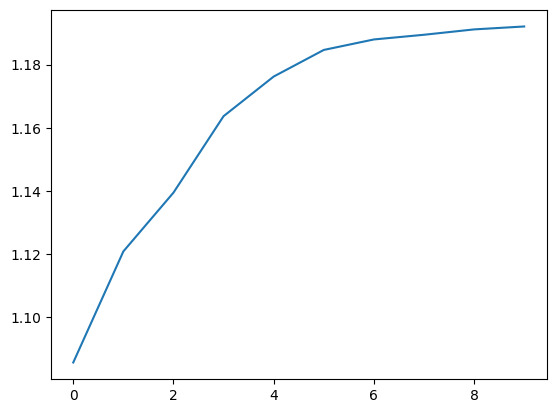

In [114]:
plt.plot(final_expectations)

In [115]:
final_expectations[-1]

1.1920651933078004

In [116]:
xx_unitary = unitaries

In [117]:
xx_state = new_top_b_tensors

In [118]:
xx_schmidt_values = new_schmidt_values

In [119]:
symmetry_action_unitaries.append(unitaries)

# Multiply unitary against state

In [120]:
unitaries[0]

[<npc.Array shape=(128, 128) labels=['(p0.p1.p2.p3.p4.p5.p6)', '(p0*.p1*.p2*.p3*.p4*.p5*.p6*)']>,
 <npc.Array shape=(128, 128) labels=['(p0.p1.p2.p3.p4.p5.p6)', '(p0*.p1*.p2*.p3*.p4*.p5*.p6*)']>,
 <npc.Array shape=(128, 128) labels=['(p0.p1.p2.p3.p4.p5.p6)', '(p0*.p1*.p2*.p3*.p4*.p5*.p6*)']>,
 <npc.Array shape=(16, 16) labels=['(p0.p1.p2.p3)', '(p0*.p1*.p2*.p3*)']>]

In [121]:
def get_num_legs(unitary):
    ll = unitary.get_leg_labels()[0]

    return len(ll[1:-1].split('.'))

In [122]:
def group_by_lengths(l, lengths):
    out = list()

    current_index = 0

    for n in lengths:
        current_group = l[current_index:current_index+n]
        out.append(current_group)

        current_index += n

    return out

In [123]:
def multiply_unitaries_against_mps(unitaries, b_tensors, left_schmidt_values,
                                  max_virtual_bond_dim=MAX_VIRTUAL_BOND_DIM):
    site_group_lens = [get_num_legs(u) for u in unitaries]

    grouped_bs = group_by_lengths(b_tensors, site_group_lens)
    grouped_schmidt_values = group_by_lengths(
        left_schmidt_values,
        site_group_lens
    )

    combined_bs = combine_grouped_b_tensors(grouped_bs)

    for i, u in enumerate(unitaries):
        b = combined_bs[i]
        ll = get_physical_leg_labels(b)[0]
        llh = conjugate_leg_label(ll)
    
        new_b = npc.tensordot(b, u, [[ll,], [llh,]])
    
        combined_bs[i] = new_b

    new_top_bs = list()
    new_left_schmidt_values = left_schmidt_values.copy()

    for b, s in zip (combined_bs, grouped_schmidt_values):
        leg_label = get_physical_leg_labels(b)[0]
        if is_single_physical_leg_label(leg_label):
            new_top_bs.append(b)
            new_left_schmidt_values.extend(s)
        elif is_grouped_physical_leg_label(leg_label):
            bs, schmidt_vals = split_combined_b(
                b,
                s[0],
                max_virtual_bond_dim
            )
            new_top_bs.extend(bs)
            new_left_schmidt_values.extend(s)

    return new_top_bs, new_left_schmidt_values

In [147]:
def multiply_stacked_unitaries_against_mps(unitaries, b_tensors, left_schmidt_values):
    out_b_tensors = b_tensors.copy()
    out_left_schmidt_values = left_schmidt_values.copy()

    for l in unitaries:
        out_b_tensors, out_left_schmidt_values = multiply_unitaries_against_mps(
            l,
            out_b_tensors,
            out_left_schmidt_values
        )

    return out_b_tensors, out_left_schmidt_values

## Test
Check if agrees with optimisation output.

### IX

In [148]:
ix_out_state_test, _ = multiply_stacked_unitaries_against_mps(ix_unitary, bs, left_schmidt_values)

In [149]:
ix_out_state_test

[<npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Arra

In [150]:
def mps_inner_product(
        top_tensors, bottom_tensors, left_environment):

    b_top = top_tensors[0]
    b_bottom = bottom_tensors[0]

    t = npc.tensordot(left_environment, b_bottom.conj(), (['vR*',], ['vL*',]))
    t = npc.tensordot(t, b_top, (['vR', 'p*'], ['vL', 'p']))

    for b_top, b_bottom in zip(top_tensors[1:], bottom_tensors[1:]):
        t = npc.tensordot(t, b_bottom.conj(), (['vR*',], ['vL*',]))
        t = npc.tensordot(t, b_top, (['vR', 'p*'], ['vL', 'p']))

    e = npc.trace(t, 'vR', 'vR*')

    return e

In [151]:
mps_inner_product(
    ix_out_state_test,
    bs,
    cases[0].right_projected_symmetry_state
)

(1.1940487223514105+0j)

In [152]:
mps_inner_product(
    ix_state,
    bs,
    cases[0].right_projected_symmetry_state
)

(1.1940487223514105+0j)

Looks good.

# Calculate phase

In [153]:
xi_ix_state, _ = multiply_stacked_unitaries_against_mps(xi_unitary, ix_state, ix_schmidt_values)

Step through

In [154]:
trivial_case = SymmetryActionWithBoundaryUnitaries(test_psi, [np_I, np_I]*50)

In [155]:
trivial_case.compute_svd_symmetry_action()

In [156]:
mps_inner_product(
    xi_ix_state,
    xx_state,
    trivial_case.right_projected_symmetry_state
)

(1.1975523326582458+0j)

In [157]:
X = np.round(trivial_case.right_projected_symmetry_state.to_ndarray(), 3)

In [158]:
np.diag(X)

array([-0.99 +0.j, -0.1  +0.j, -0.099+0.j, -0.01 +0.j, -0.   +0.j,
       -0.   +0.j, -0.   +0.j, -0.   +0.j])

Just schmidt values...?

In [159]:
np.sum(np.power(X, 2))

(1.000001+0j)

In [160]:
xi_xx_state, _ = multiply_stacked_unitaries_against_mps(xi_unitary, xx_state, xx_schmidt_values)

In [161]:
mps_inner_product(
    xi_xx_state,
    ix_state,
    trivial_case.right_projected_symmetry_state
)

(1.1953998932984975+0j)

In [162]:
ix_xx_state, _ = multiply_stacked_unitaries_against_mps(ix_unitary, xx_state, xx_schmidt_values)

In [163]:
mps_inner_product(
    ix_xx_state,
    xi_state,
    trivial_case.right_projected_symmetry_state
)

(1.1956570612643547+0j)

In [164]:
ix_ix_state, _ = multiply_stacked_unitaries_against_mps(ix_unitary, ix_state, ix_schmidt_values)

In [165]:
mps_inner_product(
    ix_ix_state,
    bs,
    trivial_case.right_projected_symmetry_state
)

(-1.193071117405115+0j)

In [166]:
xi_xi_state, _ = multiply_stacked_unitaries_against_mps(xi_unitary, xi_state, xi_schmidt_values)

In [167]:
mps_inner_product(
    xi_xi_state,
    bs,
    trivial_case.right_projected_symmetry_state
)

(-1.1941238632124107+0j)

In [168]:
xx_xx_state, _ = multiply_stacked_unitaries_against_mps(xx_unitary, xx_state, xx_schmidt_values)

In [169]:
mps_inner_product(
    xx_xx_state,
    bs,
    trivial_case.right_projected_symmetry_state
)

(-1.189810359700974+0j)

## "Gauge invariant" phase

In [153]:
xi_ix_state, _ = multiply_stacked_unitaries_against_mps(xi_unitary, ix_state, ix_schmidt_values)

In [170]:
ix_xi_state, _ = multiply_stacked_unitaries_against_mps(ix_unitary, xi_state, xi_schmidt_values)

In [155]:
trivial_case.compute_svd_symmetry_action()

In [171]:
mps_inner_product(
    xi_ix_state,
    ix_xi_state,
    trivial_case.right_projected_symmetry_state
)

(-1.1973178380302152+0j)

In [160]:
xi_xx_state, _ = multiply_stacked_unitaries_against_mps(xi_unitary, xx_state, xx_schmidt_values)

In [172]:
xx_xi_state, _ = multiply_stacked_unitaries_against_mps(xx_unitary, xi_state, xi_schmidt_values)

In [173]:
mps_inner_product(
    xi_xx_state,
    xx_xi_state,
    trivial_case.right_projected_symmetry_state
)

(-1.1980297924298529+0j)

In [162]:
ix_xx_state, _ = multiply_stacked_unitaries_against_mps(ix_unitary, xx_state, xx_schmidt_values)

In [176]:
xx_ix_state, _ = multiply_stacked_unitaries_against_mps(xx_unitary, ix_state, ix_schmidt_values)

In [177]:
mps_inner_product(
    ix_xx_state,
    xx_ix_state,
    trivial_case.right_projected_symmetry_state
)

(-1.1984923864860941+0j)

All negative... non trivial state? What's going wrong? Has to be something to do with the environmnet?